In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.optim as optim
from skimage.metrics import structural_similarity as ssim
import numpy as np

class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(True),
            nn.Linear(256, bottleneck_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
def add_gaussian_noise(images, sigma):
    return images + sigma * torch.randn_like(images)

def train_autoencoder(sigma, bottleneck_dim=64, epochs=10):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = Autoencoder(bottleneck_dim=bottleneck_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(epochs):
        for data in train_loader:
            imgs, _ = data
            noisy_imgs = add_gaussian_noise(imgs, sigma)
            optimizer.zero_grad()
            outputs = model(noisy_imgs)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()

    model.eval()
    ssim_scores = []
    with torch.no_grad():
        for data in test_loader:
            imgs, _ = data
            noisy_imgs = add_gaussian_noise(imgs, sigma)
            outputs = model(noisy_imgs)
            for i in range(imgs.size(0)):
                original_img = imgs[i].view(28, 28).numpy()
                output_img = outputs[i].view(28, 28).numpy()
                ssim_scores.append(ssim(original_img, output_img))

    return np.mean(ssim_scores)


In [ ]:
import matplotlib.pyplot as plt

def plot_ssim_scores(x, ssim_scores, title, xlabel):
    plt.figure(figsize=(10, 6))
    plt.plot(x, ssim_scores, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Average SSIM Score')
    plt.grid(True)
    plt.show()



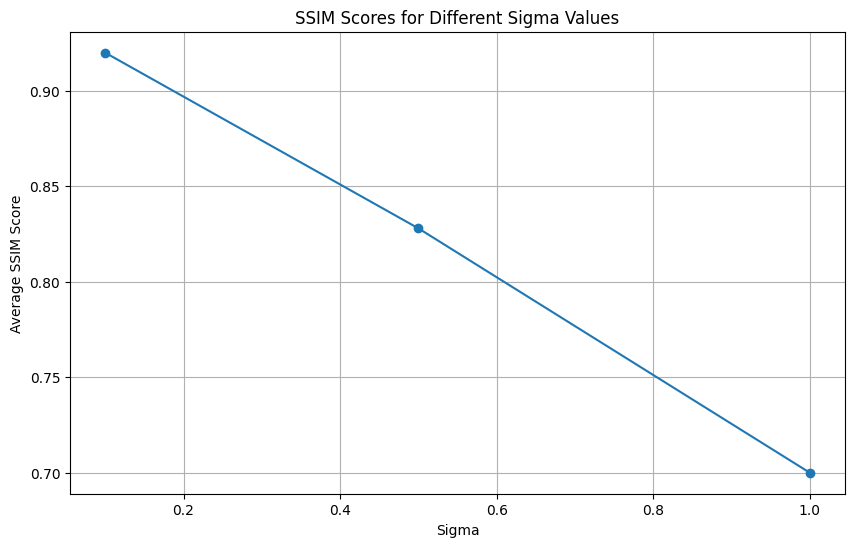

In [ ]:
# Experiment 1: Varying Sigma
sigma_values = [0.1, 0.5, 1.0]
ssim_scores_sigma = []
for sigma in sigma_values:
    score = train_autoencoder(sigma=sigma, bottleneck_dim=64, epochs=5)
    ssim_scores_sigma.append(score)

plot_ssim_scores(sigma_values, ssim_scores_sigma, 'SSIM Scores for Different Sigma Values', 'Sigma')



In [ ]:
for sigma, ssim_score in zip(sigma_values, ssim_scores_sigma):
    print(f"Sigma = {sigma}, Average SSIM Score: {ssim_score:.4f}")

Sigma = 0.1, Average SSIM Score: 0.9198
Sigma = 0.5, Average SSIM Score: 0.8279
Sigma = 1.0, Average SSIM Score: 0.7001


## Observations:
* As sigma increases, which implies that more noise is added to the images, the average SSIM score decreases. This trend is linear and quite strong, indicating a clear inverse relationship between the level of noise in the images and the quality of the image reconstruction as judged by the SSIM score.
* When sigma is low (close to 0.1), the SSIM score is high, around 0.9, suggesting that the model's reconstructions are very similar to the original images. As sigma increases to 1.0, the SSIM score drops to around 0.7, which indicates that the reconstruction quality has significantly deteriorated due to the higher noise level.
* This observation aligns well with expectations: introducing more noise to the input images makes it more challenging for the autoencoder to learn and reconstruct the important features of the original data. The model's ability to accurately reconstruct the original image degrades as the noise distracts or masks the true underlying patterns in the data.








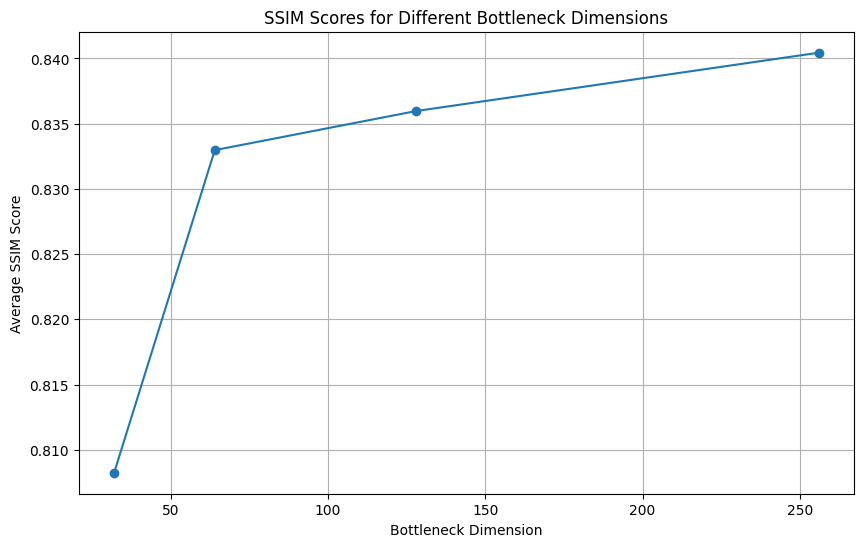

In [ ]:
# Experiment 2: Varying Bottleneck Dimensionality
bottleneck_dims = [32, 64, 128, 256]
ssim_scores_bottleneck = []
for dim in bottleneck_dims:
    score = train_autoencoder(sigma=0.5, bottleneck_dim=dim, epochs=5)
    ssim_scores_bottleneck.append(score)

plot_ssim_scores(bottleneck_dims, ssim_scores_bottleneck, 'SSIM Scores for Different Bottleneck Dimensions', 'Bottleneck Dimension')


In [ ]:
for bottleneck, ssim_score_b in zip(bottleneck_dims, ssim_scores_bottleneck):
    print(f"Sigma = {bottleneck}, Average SSIM Score: {ssim_score_b:.4f}")

Sigma = 32, Average SSIM Score: 0.8082
Sigma = 64, Average SSIM Score: 0.8330
Sigma = 128, Average SSIM Score: 0.8360
Sigma = 256, Average SSIM Score: 0.8404


## Observation:
* The graph starts with a lower SSIM score at a small bottleneck dimension and progressively climbs as the bottleneck dimension increases. This suggests that with more capacity in the bottleneck (more neurons), the autoencoder is better able to capture the essential features of the data necessary for a high-quality reconstruction.
* A larger bottleneck dimension provides a greater capacity for the autoencoder to learn representations. If the bottleneck is too small, the autoencoder may not have enough capacity to encode all the relevant features of the input data.